In [1]:
#initialization
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.linalg as la
# importing Qiskit
from qiskit import transpile, assemble, BasicAer, execute

# from qiskit_aer import Aer
# from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit#, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

# importing Qiskit
from qiskit.quantum_info import DensityMatrix
from qiskit.extensions import UnitaryGate

In [21]:
# hermitian_eigs = [0,
#                   0.25,
#                   0.75,
#                   0.5]
# A = np.diag(hermitian_eigs).astype('complex')
# eigs_h, vecs_h = np.linalg.eig(A)
# RESULTS = []

qubit_num = 2 #число кубитов для вычисления собственного значения
# real_unitary_eigs = np.repeat(
#     a=[la.expm(1j*2*np.pi*(1)/(2**qubit_num)) for _ in range(2**qubit_num)],
#     repeats=1)
real_unitary_eigs = [
    1*2*np.pi*(0)/(2**qubit_num),
    1*2*np.pi*(1)/(2**qubit_num),
    1*2*np.pi*(2)/(2**qubit_num),
    1*2*np.pi*(3)/(2**qubit_num)
]
print(real_unitary_eigs)
# print(real_unitary_eigs)
A = np.diag(real_unitary_eigs).astype('complex')
# print(eigs_h)

[0.0, 1.5707963267948966, 3.141592653589793, 4.71238898038469]


In [22]:

ERROR = 0.0
def add_noise_to_gate(U):
    noise = np.random.uniform(-ERROR,ERROR,U.shape)
    noise = noise + noise.conj().T
    U_noise = la.expm(1j*(noise.T))
    U = np.dot(U_noise, U)
    return U

In [87]:
U = la.expm(1j*A)
# U = np.load('matrix.npy')
# check on unitarnyness
UnitaryGate(U)
eigs_u, vecs_u = np.linalg.eig(U)

In [70]:
# n_of_qubs = 3
# qpe = QuantumCircuit(n_of_qubs+2, n_of_qubs)
# qpe.initialize(vecs_u[1], [-2, -1])
# vecs_u[1]
n_of_qubs = qubit_num #3
qubs_for_vec = np.arange(-np.log2(U.shape[0]), 0).astype(int)
qpe = QuantumCircuit(n_of_qubs+len(qubs_for_vec), n_of_qubs)
# print(vecs_u[0])
qpe.initialize(vecs_u[3], [*qubs_for_vec])
# qpe.draw()

In [71]:
qpe_clear = QuantumCircuit(n_of_qubs+len(qubs_for_vec))
for qubit in range(n_of_qubs):
    qpe_clear.h(qubit)

# print(qpe_clear)

In [72]:
backend = BasicAer.get_backend('unitary_simulator')
job = backend.run(qpe_clear, shots=2048)
# job = execute(qpe_clear, backend)
result = job.result()
op = result.get_unitary(qpe_clear).data
# op = add_noise_to_gate(op)
U_h = UnitaryGate(op)
np.shape(U_h)

(16, 16)

In [73]:
qpe.append(U_h, range(n_of_qubs+len(qubs_for_vec)))    
# qpe.draw()

In [74]:
from qiskit.circuit.library import UnitaryGate
repetitions = 1
for i in range(n_of_qubs):
    for rep in range(repetitions):
        qpe.append(UnitaryGate(U).control(1), [i, *qubs_for_vec])
    repetitions *= 2

# qpe.draw()

In [75]:
qpe.draw()

┌──────────┐                                    
q_0: ────────────────────────┤0         ├─────■──────────────────────────────
                             │          │     │                              
q_1: ────────────────────────┤1         ├─────┼───────────■───────────■──────
     ┌──────────────────────┐│  Unitary │┌────┴─────┐┌────┴─────┐┌────┴─────┐
q_2: ┤0                     ├┤2         ├┤0         ├┤0         ├┤0         ├
     │  Initialize(0,0,0,1) ││          ││  Unitary ││  Unitary ││  Unitary │
q_3: ┤1                     ├┤3         ├┤1         ├┤1         ├┤1         ├
     └──────────────────────┘└──────────┘└──────────┘└──────────┘└──────────┘
c: 2/════════════════════════════════════════════════════════════════════════

In [76]:
# circ = QuantumCircuit(n_of_qubs+1, n_of_qubs)
# from qiskit.circuit.library import UnitaryGate
# repetitions = 1
# for i in range(n_of_qubs):
#     for rep in range(repetitions):
#         circ.append(UnitaryGate(U).control(1), [i, -2, -1])
#     repetitions *= 2
# backend = Aer.get_backend('unitary_simulator')
# job = execute(circ, backend)
# result = job.result()
# op = result.get_unitary(circ).data
# op = add_noise_to_gate(op)
# U_h = UnitaryGate(op)
# np.set_printoptions(threshold=np.inf)
# np.shape(op)
# np.round(op,3)
# qpe.draw()

In [77]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2): #n//2
        qc.swap(qubit, n-qubit-1)
    for j in range(n): #n
        # print(f"j{j}")
        for m in range(j):
            # print(f"m{m}")
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)
    

In [78]:
# del
# qpe_clear = QuantumCircuit(3)
# qft_dagger(qpe_clear, 3)
# backend = Aer.get_backend('unitary_simulator')
# job = execute(qpe_clear, backend)
# result = job.result()
# op = result.get_unitary(qpe_clear).data
# # print(op.shape)
# # np.round(op, 2)
# # 
# U_h = UnitaryGate(op)
# qpe_clear = QuantumCircuit(3+2) #(n_of_qubs+1)
# qpe_clear.append(U_h, range(3)) #(U_h, range(n_of_qubs))
# backend = Aer.get_backend('unitary_simulator')
# job = execute(qpe_clear, backend)
# result = job.result()
# op = result.get_unitary(qpe_clear).data
# np.round(op, 2)
# op.shape

In [79]:
# # Apply inverse QFT
qpe_clear = QuantumCircuit(n_of_qubs)
qft_dagger(qpe_clear, n_of_qubs)
backend = BasicAer.get_backend('unitary_simulator')
job = execute(qpe_clear, backend)
result = job.result()
op = result.get_unitary(qpe_clear).data
# print(qpe_clear)

In [80]:
# print(qpe_clear)
qpe_clear.draw()

┌───┐               
q_0: ─X─┤ H ├─■─────────────
      │ └───┘ │P(-π/2) ┌───┐
q_1: ─X───────■────────┤ H ├
                       └───┘

In [81]:
U_h = UnitaryGate(op)
qpe.append(U_h, range(n_of_qubs))

In [82]:
# np.round(DensityMatrix(qpe), 4)
# np.set_printoptions(threshold=np.inf)
# np.round(DensityMatrix(qpe), 3)

In [83]:
qpe.draw()

┌──────────┐                                    »
q_0: ────────────────────────┤0         ├─────■──────────────────────────────»
                             │          │     │                              »
q_1: ────────────────────────┤1         ├─────┼───────────■───────────■──────»
     ┌──────────────────────┐│  Unitary │┌────┴─────┐┌────┴─────┐┌────┴─────┐»
q_2: ┤0                     ├┤2         ├┤0         ├┤0         ├┤0         ├»
     │  Initialize(0,0,0,1) ││          ││  Unitary ││  Unitary ││  Unitary │»
q_3: ┤1                     ├┤3         ├┤1         ├┤1         ├┤1         ├»
     └──────────────────────┘└──────────┘└──────────┘└──────────┘└──────────┘»
c: 2/════════════════════════════════════════════════════════════════════════»
                                                                             »
«     ┌──────────┐
«q_0: ┤0         ├
«     │  Unitary │
«q_1: ┤1         ├
«     └──────────┘
«q_2: ────────────
«                 
«q_3: ────────────
«                 
«c: 2/════════════
«

In [84]:
# from qiskit.providers.aer import Aer 

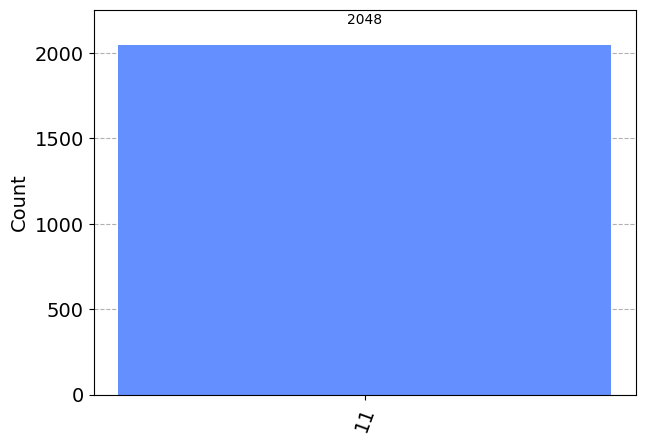

In [85]:
for n in range(n_of_qubs):
    qpe.measure(n,n)
aer_sim = BasicAer.get_backend('qasm_simulator')
shots = 2048
# t_qpe = transpile(qpe, aer_sim)
# qobj = assemble(t_qpe, shots=shots)
qobj=execute(qpe,aer_sim,shots=shots)
# results = aer_sim.run(qobj).result()
results = qobj.result()
answer = results.get_counts()
answer_to_plot = answer.copy()
answer = sorted(answer.items(), key=lambda x:x[1])
new_ans = []
for pair in answer:
    new_ans.append((int(pair[0],2), pair[1]))
answer = new_ans
plot_histogram(answer_to_plot)

### Реальные значения искомых собственных значений унитарной матрицы:

In [86]:
eigs_u

array([ 1.0000000e+00+0.0000000e+00j,  6.1232340e-17+1.0000000e+00j,
       -1.0000000e+00+1.2246468e-16j, -1.8369702e-16-1.0000000e+00j])

### Распределение полученных ответов по типу $[(n_1, n_{shots}), (n_2, n_{shots}), (n_3, n_{shots}), ..., (n_n, n_{shots})]$,
### где $n_n$ - десятичное измеренное число, $n_{shots}$ - число измерений

In [22]:
print(answer)

[(0, 2048)]


### Формула, по которой можно расчитать собственное значение выглядит как $e^{j\cdot 2\cdot \pi \cdot n/(2^{n_{qubs}})}$,
### где $n$ - десятичное измеренное число, $n_{qubs}$ - число кубитов (ниже используется как n_of_qubs)

In [18]:
import scipy.linalg as la
print(la.expm(1j*2*np.pi*2/(2**n_of_qubs)))

[[6.123234e-17+1.j]]


### Подстановка желаемого числа кубитов и желаемого измеренного десятичного числа позволяет искусственно сгенерировать желаемые собственные значения.
### Например, пусть мы имеем 4 кубита и хотим иметь 3 и 1 как результат десятичного измеренного числа. Тогда собственные числа $eig_u$ унитарной матрицы могут быть посчитаны следующим образом:
```
print(la.expm(1j*2*np.pi*3/(2**4)))
print(la.expm(1j*2*np.pi*1/(2**4)))
```
```
out:
[[0.38268343+0.92387953j]]
[[0.92387953+0.38268343j]]
```

In [25]:
print(la.expm(1j*2*np.pi*1/(2**3)))
print(la.expm(1j*2*np.pi*2/(2**3)))
print(la.expm(1j*2*np.pi*3/(2**3)))
print(la.expm(1j*2*np.pi*4/(2**3)))
print(la.expm(1j*2*np.pi*5/(2**3)))
print(la.expm(1j*2*np.pi*6/(2**3)))
print(la.expm(1j*2*np.pi*7/(2**3)))
print(la.expm(1j*2*np.pi*0/(2**3)))

[[0.70710678+0.70710678j]]
[[6.123234e-17+1.j]]
[[-0.70710678+0.70710678j]]
[[-1.+1.2246468e-16j]]
[[-0.70710678-0.70710678j]]
[[-1.8369702e-16-1.j]]
[[0.70710678-0.70710678j]]
[[1.+0.j]]


### Тогда диагональные элементы эрмитовой матрицы имеют вид $log(eig_u)$:
```
print(np.log(0.92387953+0.38268343j))
```
```
out:
(-3.225207111789145e-09+0.39269908047469393j)
```

In [26]:
print(np.log(0.70710678+0.70710678j))
print(np.log(6.123234e-17+1.j))
print(np.log(-0.70710678+0.70710678j))
print(np.log(-1.+1.2246468e-16j))
print(np.log(-0.70710678-0.70710678j))
print(np.log(-1.8369702e-16-1.j))
print(np.log(0.70710678-0.70710678j))
print(np.log(1.+0.j))

(-1.6780315776190748e-09+0.7853981633974483j)
(1.8746997309377998e-33+1.5707963267948966j)
(-1.6780315776190748e-09+2.356194490192345j)
(7.498798923751199e-33+3.141592653589793j)
(-1.6780315776190748e-09-2.356194490192345j)
(1.68722975784402e-32-1.5707963267948968j)
(-1.6780315776190748e-09-0.7853981633974483j)
0j


In [19]:
# circ = QuantumCircuit(5)
# circ.append(UnitaryGate(U).control(1), [1, -2, -1])
# backend = Aer.get_backend('unitary_simulator')
# job = execute(circ, backend)
# result = job.result()
# op = result.get_unitary(circ).data
# np.round(op, 3)

In [30]:
a = np.log(eigs_u[0])*((2**5)/(2*np.pi*1j))

In [31]:
print(a)
5.039153255477287

# print(np.log(eigs_u[0])*2**n_of_qubs)

(5.039153255477287-4.240739575284689e-16j)


5.039153255477287

In [32]:
eigs_u[0]

(0.5491617699847768+0.835716070437315j)